In [27]:
import numpy as np
import quflow as qf
import matplotlib.pyplot as plt
%matplotlib notebook
%config Completer.use_jedi = False
plt.rc('figure', figsize=(10,5))

# Simulation of Euler's equations on the sphere

In vorticity formulation, Euler's equations are
$$\dot\omega = \{\psi,\omega\} $$
where $\omega$ is the vorticity function and $\psi$ is the stream function
(related to $\omega$ via Poisson's equation).
The quantized Euler equations are similar
$$\dot W = [P,W] $$
but here the vorticity function is replaced by the vorticity matrix
$W \in \mathfrak{su}(N)$ and a corresponding stream matrix $P\in\mathfrak{su}(N)$.

## Create initial conditions

In [2]:
N = 128 # Size of matrices

In [3]:
W0 = qf.shr2mat(qf.as_shr(qf.load("W_0.mat")), N=N)
P0 = qf.solve_poisson(W0)
print(W0.shape)

(128, 128)


In [4]:
2.0/np.abs(np.linalg.eigvalsh(P0)).max()

33.04770733852893

<IPython.core.display.Javascript object>


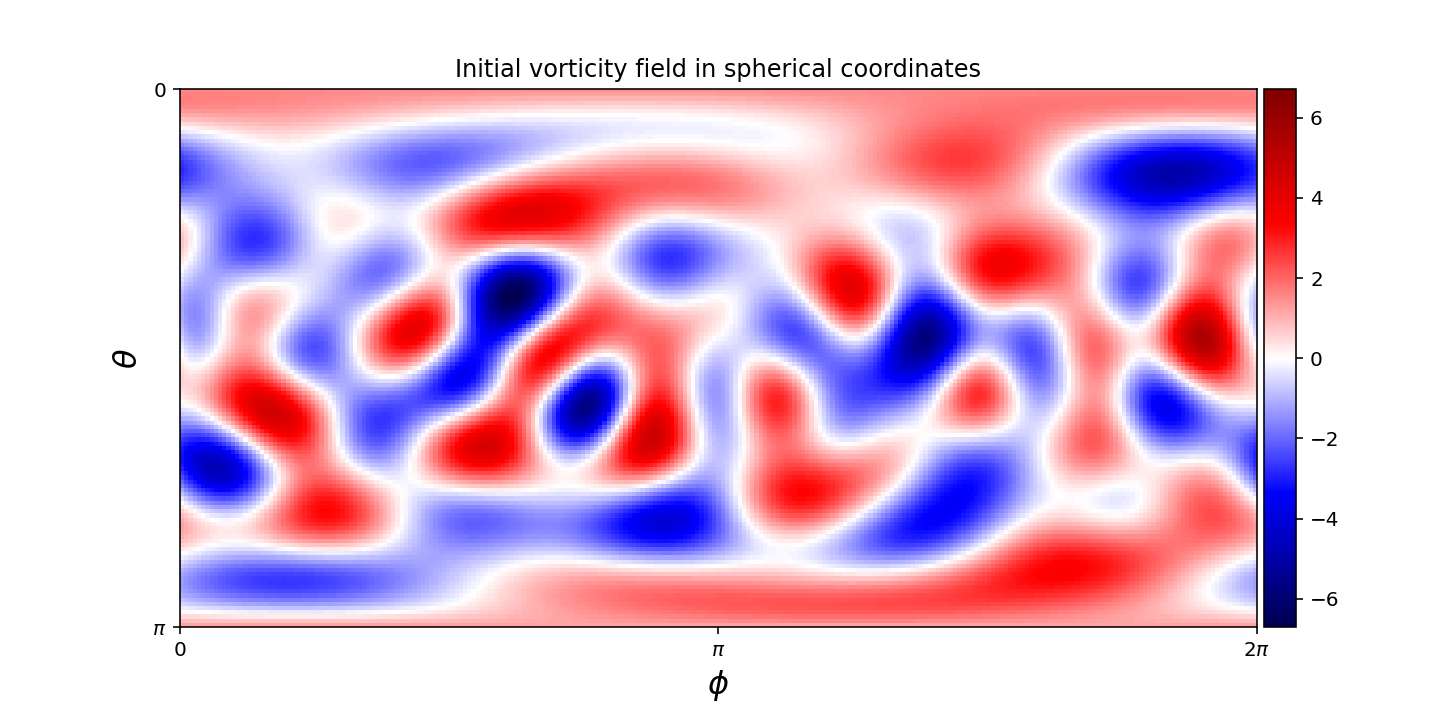

In [28]:
ax = qf.plot(W0) # Display initial vorticity using spherical coordinates
ax.axes.set_title('Initial vorticity field in spherical coordinates');

In [12]:
%%time
W = W0.copy()
qf.isomp(W, stepsize=5.0, steps=300)
print('Finished!')

Finished!
CPU times: user 13.3 s, sys: 1.36 s, total: 14.6 s
Wall time: 3.39 s


<IPython.core.display.Javascript object>


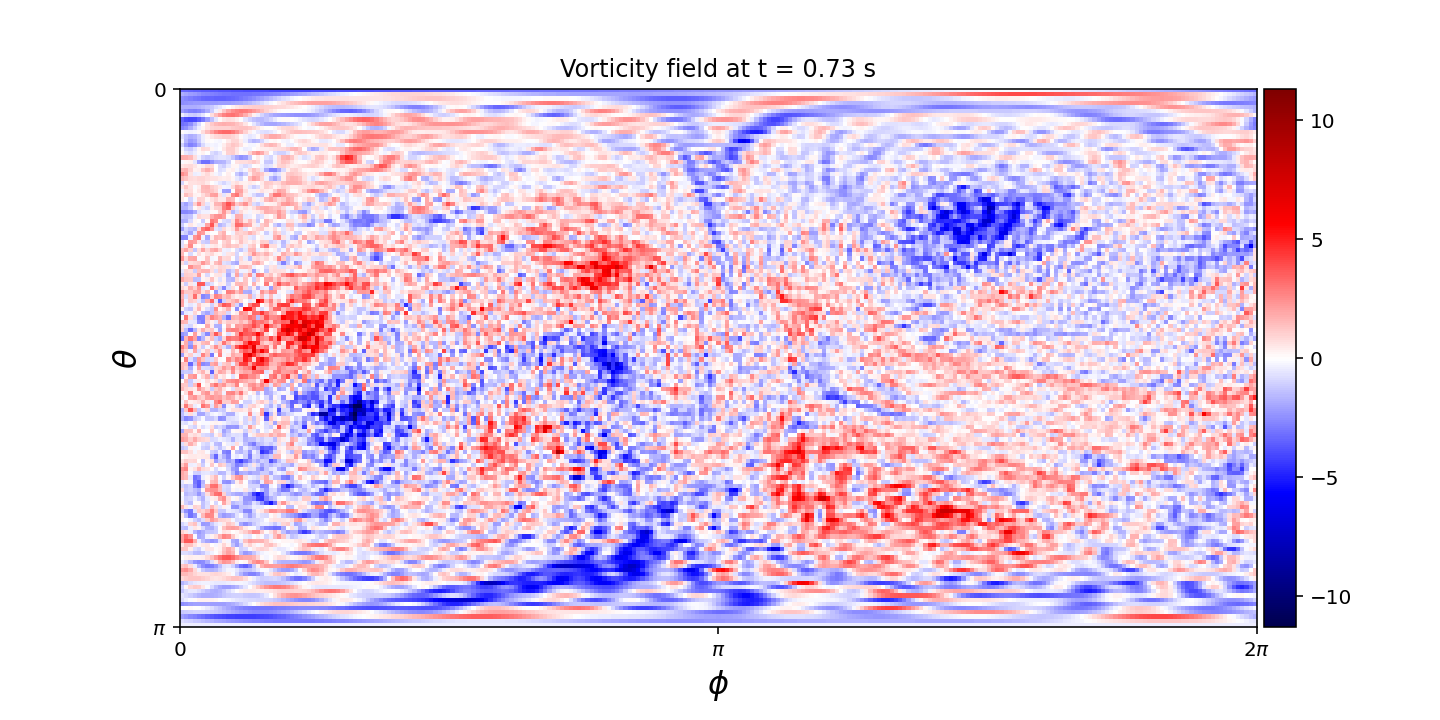

In [42]:
ax = qf.plot(W) # Display initial vorticity using spherical coordinates
ax.axes.set_title("Vorticity field at t = {:.2f} s".format(qf.qtime2seconds(0.5*300, N)));

## Run simulation and animate the results

<IPython.core.display.Javascript object>


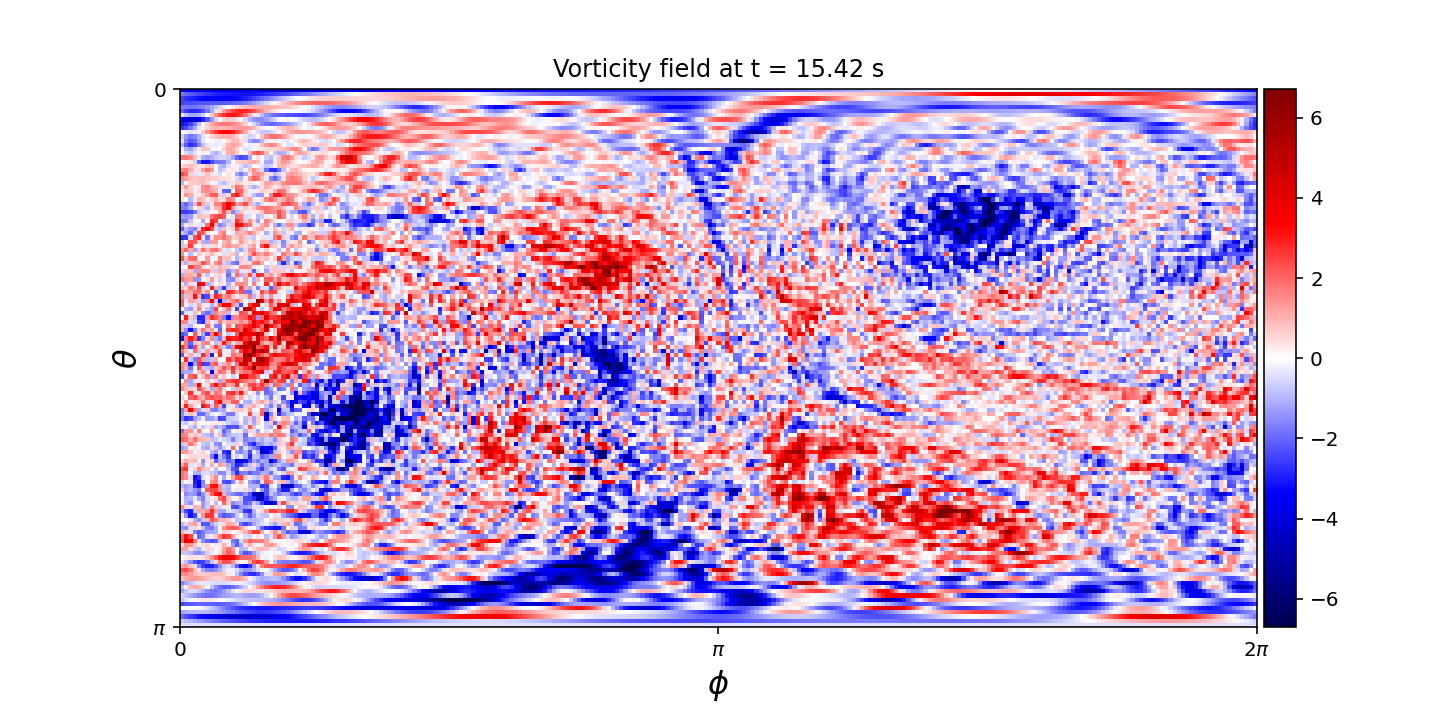

In [41]:
from matplotlib.animation import FuncAnimation

W = W0.copy()
img_ax = qf.plot(W)
h = 3.0 # Stepsize in qtime units
steps_per_frame = 50

def animate(frame_num):
    qf.isomp(W, stepsize=h, steps=steps_per_frame)
    img_ax.set_array(qf.as_fun(W))
    img_ax.axes.set_title("Vorticity field at t = {:.2f} s".format(qf.qtime2seconds(h*steps_per_frame*frame_num, N)))
    return ax

anim = FuncAnimation(img_ax.figure, animate, frames=200, interval=20, repeat=False, blit=True)
plt.show()

## Compute canonical decomposition

In [18]:
[Ws,Wr]=qf.scale_decomposition(W)

<IPython.core.display.Javascript object>


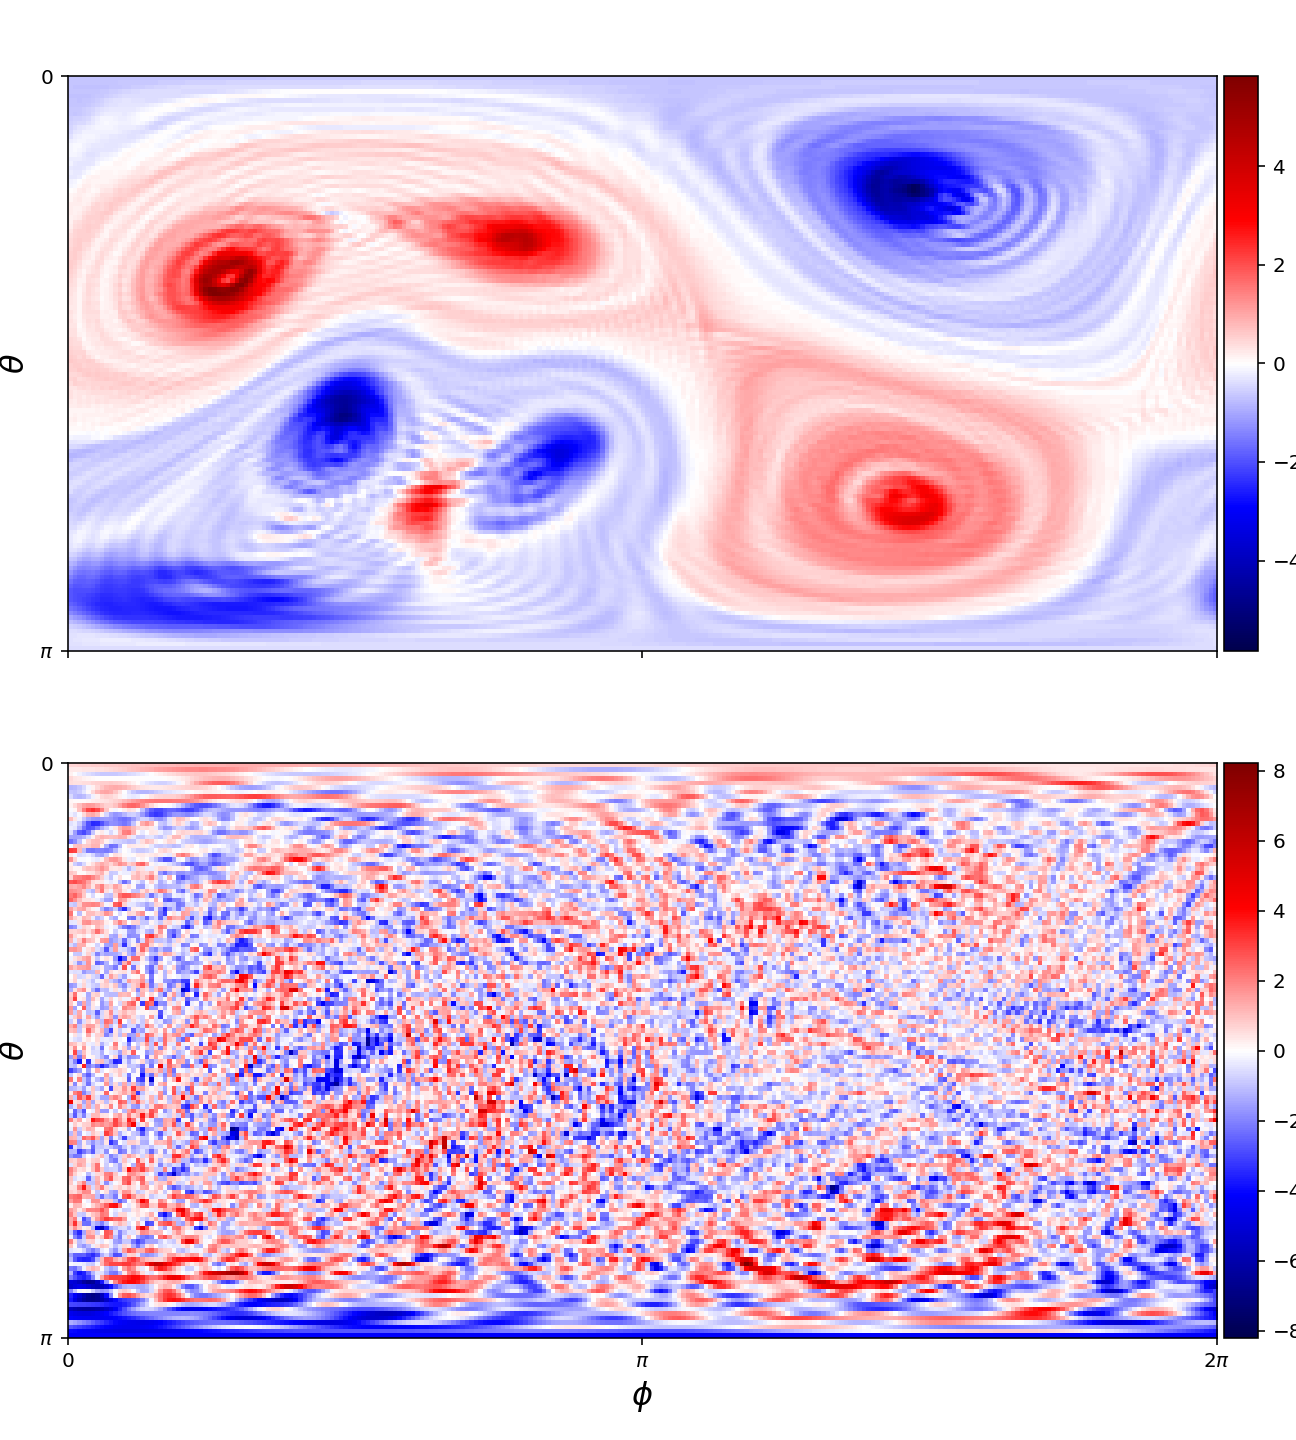

In [40]:
with plt.rc_context({'figure.figsize':(9,10)}):
    qf.plot([Ws,Wr])